# Final Project - Applied Data Science Capstone

### Introduction/Business Problem

A recognized real estate company from Guayaquil, a city in Ecuador, has an important need, which is to have a tool that tells it based on the Client's requirements such as House Size, Price, Crime Rate, Nearby Places of Interest , among others, the right place or the right places to recommend a property to the client. It may be the case that the client feels comfortable with the size of the house, number of rooms, among others, but it requires that it be close to cafes and restaurants, since it is a very busy family that always has lunch and dinner outside of the House; or at the same time that you require tourist centers such as parks or museums, since you have young children and they want a distraction center.

In short, the objective is to have a list of options that allow you to decide which house to stay with given a segment of properties that meet the characteristics required by the client. This analysis will not only save time in the search for properties by the real estate company, since it would have to see nearby places of interest one by one in some tool, but it also reduces costs and generates higher returns by presenting possible properties to the client immediately and thus be able to continue with other clients. In addition to the marketing that can be done with this tool, arguing that it is one of the best performing companies in the Ecuadorian market when it comes to finding suitable properties for the end customer.

### Data section

In this project, a csv of data collected from the olx.com.ec platform will be used, which is a website that performs digital commerce in the style of amazon or ebay, but it is more local, limiting itself to national shipments within of the countries where it is. Information was obtained at the beginning of the year (Cut January 25, 2021), a sample of the houses for sale that OLX users have published, you can almost always find the location, price and size of the land in which the house is built.

Said csv contains the following fields:
* **Code:** Unique code generated by each house for sale registered in CSV (Code generated fictitiously to generate a primary key)
* **Sector:** Name of the neighborhood where the house for sale is located
* **Latitude:** Latitude of the house for sale
* **Longitude:** Length of the house for sale
* **Size:** Land in square meters on which the house is built
* **Price:** Price published by the owner / owner or seller of the property.

In [174]:
import pandas as pd
df=pd.read_csv('D:\Documentos\houses_guayaquil.csv', sep=';')
df.head()

,Codigo,Sector,Latitud,Longitud,Tamaño,Precio
0,AC247,Acacias,-2.2417,-79.9008,309.0,110000.0
1,AC246,Acacias,-2.2467,-79.8966,308.0,145000.0
2,AC129,Acacias,-2.2465,-79.9026,194.0,185000.0
3,AR308,Acuarelas del Rio,-2.1299,-79.8809,170.0,165000.0
4,AR380,Acuarelas del Rio,-2.1351,-79.8825,230.0,176000.0


This database, which is a sample of the houses published in OLX, has certain limitations which will be listed:
1. In the first place, it is a sample in time of the houses published, which is updated day by day, and trends may change. There should be an automatic clustering model that generates the groups instantly with the information of the houses for sale at present, but for the purpose of study it will be done with this csv.
2. In addition, both the land and the price are not measured by an appraiser, these measurements can be biased by the seller of the property, for example, a person can put a price much higher than the market price of the property, or the land that they put as a property feature may be greater than it actually is. There are also certain times in which by Ecuadorian culture the price is much higher, because you bargain first since the price is negotiable.
3. Finally, another major limitation is the lack of global information on houses for sale, it would be necessary to take into account a master base of all the houses for sale currently in Guayaquil. As well as the large amount of missing data, the number of rooms, bathrooms, etc. could be put into the model. But most vendors do not fill in the relevant information and that is why these variables are not considered in the study. Once you have a much richer base for the city of Guayaquil with all the necessary fields, you will have a better perception of reality.

Another data source that will be used for this project is the nearby places of interest provided by the Foursquare API, which, for each location of the houses for sale, will have locations such as coffee shops, parks, among others. These two data sources will complement each other to solve the problem of segmenting the houses for sale in Guayaquil and to be able to solve the needs of the clients of the real estate company.

Since there is no crime rate registry for each sector of the houses for sale, that data source will not be used, crime studies in the city of Guayaquil are very limited to certain specific sectors of Guayaquil, but not to the whole city in general. This can be a great starting point for a second phase in this project.

Next, the database of records of houses for sale will be refined to continue with the study, in addition to making the respective connection with the Foursquare API and segmentation of the places.

## Data Preparation

First of all, we are going to load the necessary libraries both for the preparation of the data, and for the segmentation of the houses for sale.

In [217]:
import pandas as pd

import numpy as np

#! pip install geocoder
import geocoder

#!pip install geopy
from geopy.geocoders import Nominatim

#!pip install folium
import folium

import requests

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

We load the data source previously described with the pandas library, rename the fields and show the first 5 records.

In [218]:
guayaquil_data=pd.read_csv('D:\Documentos\houses_guayaquil.csv', sep=';')
guayaquil_data = guayaquil_data.rename(columns={'Codigo':'Code','Sector':'Neighborhood','Latitud':'Latitude',
                        'Longitud':'Longitude','Tamaño':'Size','Precio':'Price'}).reset_index()
guayaquil_data.drop('index', axis=1, inplace=True)
guayaquil_data.head()

,Code,Neighborhood,Latitude,Longitude,Size,Price
0,AC247,Acacias,-2.2417,-79.9008,309.0,110000.0
1,AC246,Acacias,-2.2467,-79.8966,308.0,145000.0
2,AC129,Acacias,-2.2465,-79.9026,194.0,185000.0
3,AR308,Acuarelas del Rio,-2.1299,-79.8809,170.0,165000.0
4,AR380,Acuarelas del Rio,-2.1351,-79.8825,230.0,176000.0


We make sure that the type of data is adequate to handle them later in the analyzes.

In [219]:
guayaquil_data.dtypes

Code             object
Neighborhood     object
Latitude        float64
Longitude       float64
Size            float64
Price           float64
dtype: object

We show the dimension of the generated data frame, in this case we can see that it has 132 houses in sale with 6 variables.

In [220]:
guayaquil_data.shape

(132, 6)

We eliminate records where houses have no price or size, to simplify the segmentation problem and show the final dimension.

In [221]:
guayaquil_data.drop(guayaquil_data[guayaquil_data['Price'].isna()].index, axis=0, inplace=True)
guayaquil_data.drop(guayaquil_data[guayaquil_data['Size'].isna()].index, axis=0, inplace=True)
guayaquil_data.shape

(129, 6)

We made a frequency histogram of the price of the houses for sale.

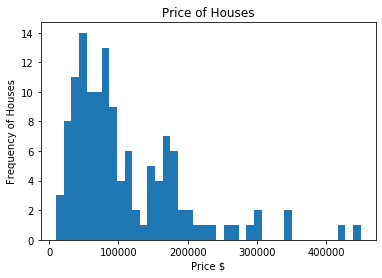

In [223]:
plt.title('Price of Houses')
plt.hist(guayaquil_data['Price'], bins = 40)
plt.xlabel('Price $')
plt.ylabel('Frequency of Houses')
plt.show()

We made a frequency histogram of the size of the houses for sale.

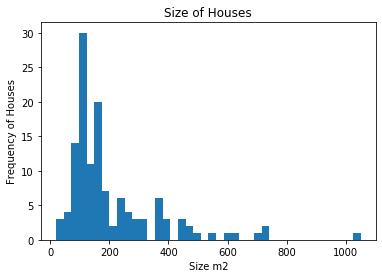

In [222]:
plt.title('Size of Houses')
plt.hist(guayaquil_data['Size'], bins = 40)
plt.xlabel('Size m2')
plt.ylabel('Frequency of Houses')
plt.show()

We describe the price and size fields of the houses for sale, we can see that on average the size is around 207 square meters, while the average price is $ 109k.

In [224]:
guayaquil_data[['Size','Price']].describe()

,Size,Price
count,129.000000,129.000000
mean,207.333333,109141.085271
std,163.793522,82188.045257
min,20.000000,10000.000000
25%,104.000000,50000.000000
50%,150.000000,83000.000000
75%,250.000000,160000.000000
max,1050.000000,450000.000000


We can visualize the location of the houses through maps created by the folium library, but first we obtain a Guayaquil landmark through the geolocator library.

In [225]:
address = 'Guayaquil, Ecuador'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are -2.1704143, -79.90502408427746.


We plot the points of each house on top of the folium map.

In [226]:
map_guayaquil = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, code, neighborhood in zip(guayaquil_data['Latitude'], guayaquil_data['Longitude'], guayaquil_data['Code'], guayaquil_data['Neighborhood']):
    label = '{}, {}'.format(code, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_guayaquil)  
    
map_guayaquil

We define the necessary parameters to query the Foursquare API.

In [227]:
CLIENT_ID = 'IHZ0QMCECCKJ3HRAEDOGM0GBHHHMBEIN0CWXXWA4RLXSUHI5'
CLIENT_SECRET = 'GZ1SGFJRJU2TLWFMQ5NP1OKSOJ4KZSFEFPSPVLPHLDPVOBUF'
VERSION = '20180605'
LIMIT = 100 
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IHZ0QMCECCKJ3HRAEDOGM0GBHHHMBEIN0CWXXWA4RLXSUHI5
CLIENT_SECRET:GZ1SGFJRJU2TLWFMQ5NP1OKSOJ4KZSFEFPSPVLPHLDPVOBUF


We define the necessary functions to obtain the categories of the venues consulted to the Foursquare API, as well as a function that returns all the venues for each house.

In [229]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Code', 
                  'Code Latitude', 
                  'Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We use the function created before to obtain a dataframe that contains all the venues for each house.

In [230]:
guayaquil_venues = getNearbyVenues(names=guayaquil_data['Code'],
                                   latitudes=guayaquil_data['Latitude'],
                                   longitudes=guayaquil_data['Longitude']
                                  )

AC247
AC246
AC129
AR308
AR380
AR367
AL647
AL978
AL867
AT137
AT267
AT495
AT249
BP129
BP349
BP264
BP347
BS124
BS149
BS204
BE183
BE153
BE348
BE255
CE359
CE179
CE167
CG130
CG118
CG145
CC309
CC367
CC459
FC163
FC243
FC287
FE137
FE397
FE274
FO116
FO267
FO130
GU562
GU489
GU329
GU215
GU174
GU034
TR257
TR467
JS118
JS190
JM240
JM305
JM387
JM409
KN633
KN673
KN624
KE397
KE387
KE392
KV102
KV151
KV121
LC348
LC212
LC132
LC175
LF128
LF144
LG448
LG462
LG451
SA149
SA167
SA182
LE906
LE902
LE912
LC255
LC302
LC172
LC167
LV089
LV086
LV034
MA156
MA134
MR470
MR400
MF185
MF162
MF348
ML095
ML034
ML145
OR119
OR161
OR252
PA234
PA348
PA219
PA394
PR142
PR148
PR107
SM900
SM894
SM906
SE190
SE107
SA392
SA357
SA311
JR925
JR913
UM136
UM121
UM166
UR364
UR123
UR349
UR302
UR387
UD242
UD173
UD380
UD297


We show the dimension and the first 5 records of said dataframe created.

In [231]:
print(guayaquil_venues.shape)
guayaquil_venues.head()

(1302, 7)


,Code,Code Latitude,Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AC247,-2.2417,-79.9008,La Española,-2.239108,-79.901699,Grocery Store
1,AC247,-2.2417,-79.9008,Motel Éxtasis,-2.242538,-79.902727,Motel
2,AC247,-2.2417,-79.9008,Parque Pradera 2,-2.242138,-79.897856,Park
3,AC247,-2.2417,-79.9008,Chifa Estrella,-2.245432,-79.899831,Chinese Restaurant
4,AC246,-2.2467,-79.8966,Parque Las Amazonas,-2.246335,-79.895341,Park


We do a count to see how many venues returned for each house.

In [233]:
guayaquil_venues.groupby('Code').count().head()

,Code Latitude,Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Code,,,,,,
AC129,4,4,4,4,4,4
AC246,8,8,8,8,8,8
AC247,4,4,4,4,4,4
AL647,30,30,30,30,30,30
AL867,18,18,18,18,18,18


We print how many unique venues categories there are in our dataframe.

In [234]:
print('There are {} uniques categories.'.format(len(guayaquil_venues['Venue Category'].unique())))

There are 172 uniques categories.


We create dummies variables (1/0) for each category of venue there is, in order to clustering said dataframe. 
We add the code as the first column.

In [235]:
guayaquil_onehot = pd.get_dummies(guayaquil_venues[['Venue Category']], prefix="", prefix_sep="")

guayaquil_onehot['Code'] = guayaquil_venues['Code'] 

fixed_columns = [guayaquil_onehot.columns[-1]] + list(guayaquil_onehot.columns[:-1])
guayaquil_onehot = guayaquil_onehot[fixed_columns]

guayaquil_onehot.head()

,Code,Accessories Store,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tex-Mex Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,AC247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AC247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AC247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AC247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AC246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We show the dimension of the dataframe.

In [236]:
guayaquil_onehot.shape

(1302, 173)

We group by each House and we take the average by category of the dummy variables. If a category has a number close to 1, it is because almost all its venues are of that category and if it is close to 0 or 0, it is because there are no venues with that category. We would already have the data almost ready to model it with a Kmeans algorithm. And show the first 5 records

In [237]:
guayaquil_grouped = guayaquil_onehot.groupby('Code').mean().reset_index()
guayaquil_grouped.head()

,Code,Accessories Store,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tex-Mex Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,AC129,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,AC246,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,AC247,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,AL647,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,AL867,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.055556,0.0,...,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0


We show the dimension of said dataframe and we can realize that there are 116 houses with 233 different categories of venues

In [238]:
guayaquil_grouped.shape

(117, 173)

We added the house codes that no venue found and assign the value of zero in all its fields, the price and the size of the house were also added to the dataframe.

In [239]:
guayaquil_temp=guayaquil_data[['Code','Size','Price']]
guayaquil_grouped_final= pd.merge(guayaquil_temp, guayaquil_grouped, on='Code', how='left')
guayaquil_grouped_final.replace({None:0}, inplace=True)
guayaquil_grouped_final.head()

,Code,Size,Price,Accessories Store,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,...,Tex-Mex Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,AC247,309.0,110000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AC246,308.0,145000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC129,194.0,185000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AR308,170.0,165000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AR380,230.0,176000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We standardize the values of Size and Price of the Houses for Sale, in order to model them with the kmeans algorithm, the other fields are not necessary to standardize them, given that they are already in a dimension from 0 to 1.

In [240]:
guayaquil_grouped_final[['Size','Price']] = StandardScaler().fit_transform(guayaquil_grouped_final[['Size','Price']])
guayaquil_grouped_final.head()

,Code,Size,Price,Accessories Store,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,...,Tex-Mex Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,AC247,0.623120,0.010491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AC246,0.616991,0.438004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AC129,-0.081721,0.926591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AR308,-0.228818,0.682297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AR380,0.138925,0.816659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We show the first 5 categories of Venues by frequency of each house code.

In [241]:
num_top_venues = 5

for hood in guayaquil_grouped_final['Code']:
    print("----"+hood+"----")
    temp = guayaquil_grouped_final[guayaquil_grouped_final['Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AC247----
                venue  freq
0                Size  0.62
1  Chinese Restaurant  0.25
2       Grocery Store  0.25
3               Motel  0.25
4                Park  0.25


----AC246----
                venue  freq
0                Size  0.62
1               Price  0.44
2                Park  0.12
3  Chinese Restaurant  0.12
4        Camera Store  0.12


----AC129----
                venue  freq
0               Price  0.93
1  Chinese Restaurant  0.25
2               Motel  0.25
3          Taco Place  0.25
4           BBQ Joint  0.25


----AR308----
                       venue  freq
0                      Price  0.68
1                       Park  0.00
2   Mediterranean Restaurant  0.00
3         Mexican Restaurant  0.00
4  Middle Eastern Restaurant  0.00


----AR380----
                       venue  freq
0                      Price  0.82
1  Latin American Restaurant  0.50
2             Clothing Store  0.25
3                       Park  0.25
4                       Size  0.1

We define a function that returns the first n categories of venues for each house code.

In [242]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We call the function to return a dataframe that for each house code returns the first 10 categories of venue by frequency.

In [256]:
guayaquil_grouped_final2=guayaquil_grouped_final.drop(['Size','Price'], axis=1)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

guayaquil_venues_sorted = pd.DataFrame(columns=columns)
guayaquil_venues_sorted['Code'] = guayaquil_grouped_final2['Code']

for ind in np.arange(guayaquil_grouped_final.shape[0]):
    guayaquil_venues_sorted.iloc[ind, 1:] = return_most_common_venues(guayaquil_grouped_final2.iloc[ind, :], num_top_venues)

guayaquil_venues_sorted.head()

,Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AC247,Park,Chinese Restaurant,Grocery Store,Motel,Cupcake Shop,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
1,AC246,Park,Camera Store,Department Store,BBQ Joint,Cajun / Creole Restaurant,Cosmetics Shop,Grocery Store,Chinese Restaurant,Dance Studio,Donut Shop
2,AC129,Chinese Restaurant,Motel,BBQ Joint,Taco Place,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
3,AR308,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
4,AR380,Latin American Restaurant,Park,Clothing Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop


We create a dataframe of the dummies variables but without the house code field, since it will not be used for the Kmeans algorithm.

In [257]:
guayaquil_grouped_clustering = guayaquil_grouped_final.drop('Code', 1)
guayaquil_grouped_clustering.head()

,Size,Price,Accessories Store,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tex-Mex Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,0.623120,0.010491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.616991,0.438004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.081721,0.926591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.228818,0.682297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.138925,0.816659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We use an elbow diagram to obtain the number of K clusters to be used within the kmeans algorithm. In this case we choose the value of 5, since it is where a greater fall / peak is appreciated.

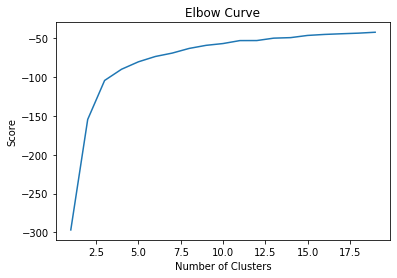

In [258]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(guayaquil_grouped_clustering).score(guayaquil_grouped_clustering) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Using the Kmeans algorithm, we model the data and show the labels of the first 10 records.

In [259]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(guayaquil_grouped_clustering)

kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 1, 1, 1, 1])

We add this information of which cluster each house code belongs to to the main dataframe where we had the information of the main 10 categories of venue by house code.

In [260]:
guayaquil_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

guayaquil_merged = guayaquil_data

guayaquil_merged = guayaquil_merged.join(guayaquil_venues_sorted.set_index('Code'), on='Code')

guayaquil_merged.head()

,Code,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AC247,Acacias,-2.2417,-79.9008,309.0,110000.0,4,Park,Chinese Restaurant,Grocery Store,Motel,Cupcake Shop,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
1,AC246,Acacias,-2.2467,-79.8966,308.0,145000.0,4,Park,Camera Store,Department Store,BBQ Joint,Cajun / Creole Restaurant,Cosmetics Shop,Grocery Store,Chinese Restaurant,Dance Studio,Donut Shop
2,AC129,Acacias,-2.2465,-79.9026,194.0,185000.0,4,Chinese Restaurant,Motel,BBQ Joint,Taco Place,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
3,AR308,Acuarelas del Rio,-2.1299,-79.8809,170.0,165000.0,4,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
4,AR380,Acuarelas del Rio,-2.1351,-79.8825,230.0,176000.0,4,Latin American Restaurant,Park,Clothing Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop


We plotted the houses codes on the Guayaquil map and painted a different color for the cluster to which they belong.

In [261]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(guayaquil_merged['Latitude'], guayaquil_merged['Longitude'], guayaquil_merged['Code'], guayaquil_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We analyze the characteristics of Cluster 0 in the dataframe with all the information of it house.

In [266]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 0, guayaquil_merged.columns[[1] + list(range(2, guayaquil_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Atarazana,-2.1760,-79.8857,380.0,170000.0,0,BBQ Joint,Grocery Store,Bowling Alley,Breakfast Spot,Restaurant,Athletics & Sports,Fried Chicken Joint,Women's Store,Donut Shop,Dive Bar
12,Atarazana,-2.1683,-79.8873,368.0,170000.0,0,Airport Terminal,South American Restaurant,Coffee Shop,Fast Food Restaurant,Electronics Store,Athletics & Sports,Deli / Bodega,Empanada Restaurant,Donut Shop,Dive Bar
22,Bellavista,-2.1886,-79.9153,460.0,210000.0,0,Park,Pharmacy,Cupcake Shop,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
24,Centenario,-2.2165,-79.8963,462.0,260000.0,0,Park,Music Venue,Pharmacy,Asian Restaurant,Restaurant,Supermarket,Women's Store,Cupcake Shop,Dive Bar,Diner
25,Centenario,-2.2158,-79.8901,500.0,195000.0,0,Pharmacy,Chinese Restaurant,Breakfast Spot,Sandwich Place,Seafood Restaurant,Fast Food Restaurant,Supermarket,Pizza Place,Department Store,Restaurant
56,Kennedy Norte,-2.1658,-79.8953,379.0,230000.0,0,Hotel,Gym,Seafood Restaurant,South American Restaurant,Coffee Shop,Fast Food Restaurant,Pharmacy,Italian Restaurant,Clothing Store,Japanese Restaurant
63,Kennedy Vieja,-2.1769,-79.9009,380.0,295000.0,0,Park,Ice Cream Shop,Gym,Latin American Restaurant,Comfort Food Restaurant,Theater,Mexican Restaurant,Plaza,Sushi Restaurant,Indian Restaurant
72,La Garzota,-2.1485,-79.8921,360.0,200000.0,0,Seafood Restaurant,Pharmacy,Chinese Restaurant,Coffee Shop,Gym,Gay Bar,Gas Station,Sandwich Place,Breakfast Spot,Cupcake Shop
88,Mapasingue,-2.1526,-79.9239,400.0,150000.0,0,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
93,Miraflores,-2.1676,-79.9185,360.0,160000.0,0,Seafood Restaurant,Supermarket,Mexican Restaurant,BBQ Joint,Juice Bar,Fast Food Restaurant,Basketball Court,Baseball Field,Burger Joint,Bakery


We analyze the characteristics of Cluster 1 in the dataframe with all the information of it house.

In [262]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 1, guayaquil_merged.columns[[1] + list(range(2, guayaquil_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Alaborada,-2.1357,-79.9054,161.0,80000.0,1,Seafood Restaurant,Pharmacy,Breakfast Spot,Fast Food Restaurant,Department Store,Latin American Restaurant,Shopping Mall,Restaurant,Bakery,Burger Joint
7,Alaborada,-2.1360,-79.8949,121.0,70000.0,1,Latin American Restaurant,Seafood Restaurant,Fried Chicken Joint,Taco Place,Big Box Store,Comfort Food Restaurant,Department Store,Electronics Store,Donut Shop,Clothing Store
8,Alborada,-2.1375,-79.8987,129.0,89000.0,1,Coffee Shop,Pizza Place,Café,Fast Food Restaurant,Seafood Restaurant,Veterinarian,Steakhouse,Snack Place,Arts & Crafts Store,Asian Restaurant
9,Atarazana,-2.1739,-79.8845,200.0,80000.0,1,Park,Fried Chicken Joint,Grocery Store,Seafood Restaurant,Fast Food Restaurant,Restaurant,Athletics & Sports,BBQ Joint,Dive Bar,Diner
11,Atarazana,-2.1731,-79.8881,95.0,69000.0,1,Athletics & Sports,Electronics Store,Fried Chicken Joint,Coffee Shop,Grocery Store,Spanish Restaurant,Bowling Alley,Restaurant,Donut Shop,Dive Bar
13,Bastion Popular,-2.0915,-79.9276,86.0,45000.0,1,Electronics Store,Women's Store,Dance Studio,Empanada Restaurant,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
14,Bastion Popular,-2.0938,-79.9225,220.0,72000.0,1,Dance Studio,Women's Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
15,Bastion Popular,-2.0981,-79.9301,113.0,53000.0,1,Health Food Store,Electronics Store,Garden Center,Dance Studio,Empanada Restaurant,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
16,Bastion Popular,-2.1026,-79.9270,120.0,95000.0,1,Garden Center,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
18,Batallon del Suburbio,-2.2258,-79.9372,150.0,30000.0,1,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega


We analyze the characteristics of Cluster 2 in the dataframe with all the information of it house.

In [263]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 2, guayaquil_merged.columns[[1] + list(range(2, guayaquil_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Centenario,-2.2200,-79.8904,1050.0,420000.0,2,Sandwich Place,Pharmacy,Pizza Place,Chinese Restaurant,Supermarket,Gym / Fitness Center,Fast Food Restaurant,Breakfast Spot,Ice Cream Shop,Professional & Other Places
28,Centro,-2.1969,-79.8823,449.0,350000.0,2,Café,Hotel,Restaurant,Latin American Restaurant,Hotel Bar,Seafood Restaurant,Dessert Shop,Shopping Mall,Church,Department Store
73,La Garzota,-2.1501,-79.8952,600.0,450000.0,2,Seafood Restaurant,Pharmacy,Multiplex,Chinese Restaurant,Coffee Shop,Beach,Gas Station,Furniture / Home Store,Breakfast Spot,Dance Studio
83,Los Ceibos,-2.1721,-79.9419,700.0,300000.0,2,Coffee Shop,Multiplex,Pizza Place,Fast Food Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Pet Store,Pharmacy,Mobile Phone Shop,Bakery
126,Urdaneta,-2.2004,-79.9009,716.0,220000.0,2,Auto Garage,Seafood Restaurant,Basketball Stadium,Restaurant,Auto Workshop,Women's Store,Deli / Bodega,Electronics Store,Donut Shop,Dive Bar
129,Urdesa,-2.1701,-79.9112,632.0,350000.0,2,Seafood Restaurant,Italian Restaurant,Pharmacy,Pizza Place,Restaurant,Sandwich Place,Chinese Restaurant,Middle Eastern Restaurant,Bar,Japanese Restaurant


We analyze the characteristics of Cluster 3 in the dataframe with all the information of it house.

In [264]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 3, guayaquil_merged.columns[[1] + list(range(2, guayaquil_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Batallon del Suburbio,-2.2272,-79.9331,455.0,43000.0,3,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
65,La Chala,-2.2101,-79.9124,454.0,93000.0,3,Chinese Restaurant,Restaurant,Event Service,Dance Studio,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
91,Martha Roldos,-2.1437,-79.9263,390.0,95000.0,3,Coffee Shop,Café,Breakfast Spot,Auto Garage,Deli / Bodega,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
103,Pascuales,-2.0769,-79.9305,720.0,30000.0,3,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega


We analyze the characteristics of Cluster 4 in the dataframe with all the information of it house.

In [265]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 4, guayaquil_merged.columns[[1] + list(range(2, guayaquil_merged.shape[1]))]]

,Neighborhood,Latitude,Longitude,Size,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acacias,-2.2417,-79.9008,309.0,110000.0,4,Park,Chinese Restaurant,Grocery Store,Motel,Cupcake Shop,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
1,Acacias,-2.2467,-79.8966,308.0,145000.0,4,Park,Camera Store,Department Store,BBQ Joint,Cajun / Creole Restaurant,Cosmetics Shop,Grocery Store,Chinese Restaurant,Dance Studio,Donut Shop
2,Acacias,-2.2465,-79.9026,194.0,185000.0,4,Chinese Restaurant,Motel,BBQ Joint,Taco Place,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
3,Acuarelas del Rio,-2.1299,-79.8809,170.0,165000.0,4,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
4,Acuarelas del Rio,-2.1351,-79.8825,230.0,176000.0,4,Latin American Restaurant,Park,Clothing Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
5,Acuarelas del Rio,-2.1344,-79.8806,200.0,170000.0,4,Latin American Restaurant,Women's Store,Falafel Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
21,Bellavista,-2.1851,-79.9109,160.0,190000.0,4,Park,Neighborhood,Asian Restaurant,Convenience Store,Dance Studio,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
23,Bellavista,-2.1873,-79.9112,255.0,145000.0,4,Park,Neighborhood,Asian Restaurant,Convenience Store,Dance Studio,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
30,Cristo del consuelo,-2.2204,-79.9106,200.0,119000.0,4,Park,Seafood Restaurant,Food Stand,Empanada Restaurant,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store,Deli / Bodega
52,Juan Montalvo,-2.1301,-79.9179,240.0,140000.0,4,Clothing Store,Stationery Store,Pool,Furniture / Home Store,Burger Joint,Women's Store,Dance Studio,Donut Shop,Dive Bar,Diner
